In [241]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from utils.utils import get_path
from utils.fig_utils import dataset_to_print
from vis_utils.plot import plot_scatter
from vis_utils.utils import load_dict
from vis_utils.loaders import load_dataset, load_small_cc_dataset
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [242]:
style_file = "utils.style"
plt.style.use(style_file)

In [243]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig 2D embeddings of single cell datasets

In [239]:
# load embeddings for all single cell dataset
data = {}


# malaria
dataset = "mca_ss2"
_, y, _, _, d = load_dataset(root_path, dataset, 15)

umap_file_name = f"{dataset}_umap_correlation_k_10_min_dist_1.0_spread_2_seed_2_init_spectral.pkl"
embd = load_dict(os.path.join(root_path, dataset, umap_file_name)).embedding_

data["mca_ss2"] = {"embd": embd,
                   "y": y,
                   "d": d}

# Neural IPC
dataset = "pallium_scVI_IPC_small"
x, y, _, _, d = load_dataset(root_path, dataset, seed=0)

umap_file_name = f"umap__k_15_metric_euclidean_epochs_750_seed_0_min_dist_0.1_init_pca.pkl"
embd = load_dict(os.path.join(root_path, dataset, umap_file_name)).embedding_
data["pallium_scVI_IPC_small"] = {"embd": d["UMAP"], # embd,
                                  "y": y,
                                  "d": d}

# other datasets
cc_datasets = ["neurosphere", "hippocampus", "HeLa2", "pancreas"]
# different provided meta data makes different type of loading necessary
for dataset in cc_datasets[:2]:
    tri_embd, y, d = load_small_cc_dataset(root_path, dataset=dataset, representation="tricycleEmbedding", seed=0)
    embd = load_dict(os.path.join(root_path, dataset+"_gopca_small", umap_file_name)).embedding_
    data[dataset] = {"embd": tri_embd,
                     "y": y,
                     "d": d}
for dataset in cc_datasets[2:]:
    tri_embd, y, _, _, d = load_dataset(root_path, dataset+"_tricycle", 15, seed=0)
    embd = load_dict(os.path.join(root_path, dataset+"_gopca", umap_file_name)).embedding_
    data[dataset] = {"embd": tri_embd,
                     "y": y,
                     "d": d}




/gpfs01/berens/user/sdamrich/mirrored_code/repos/vis_utils/vis_utils/plot.py:407: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter(*x.T, c=y, s=s, alpha=alpha, cmap=cmap, edgecolor="none", **kwargs)


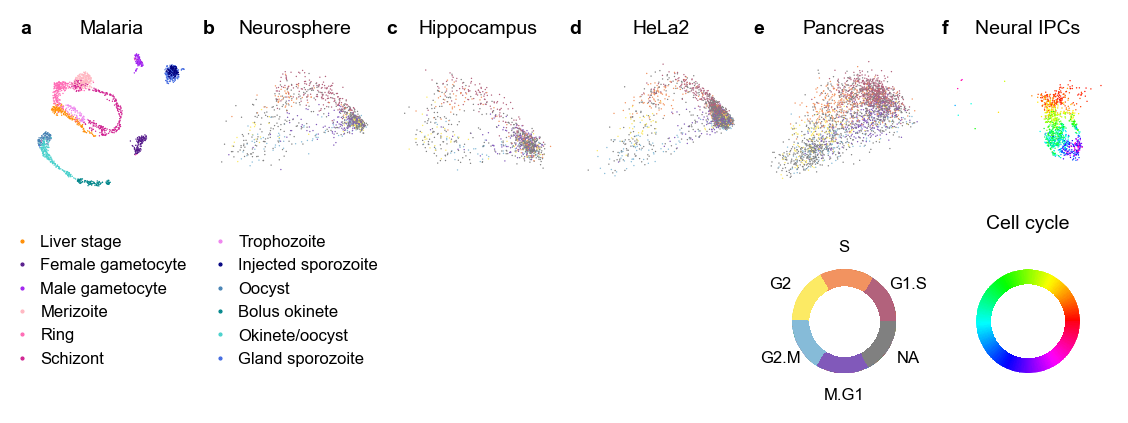

In [244]:
# plot figure
mosaic=(
    """
    abcdef
    ghijkl
    """
    
)

letters = "abcedfghijkl"

fig, ax = plt.subplot_mosaic(mosaic=mosaic,
                             #width_ratios=[1, 0.3],
                             height_ratios=[1.5,1],
                             figsize=(5.5, 2),
                             per_subplot_kw={letter: {} if letter in "abcdefg" else {"projection": "polar"} for letter in letters}
                             )

# plot malaria with legend
plot_scatter(ax=ax["a"], 
             x=data["mca_ss2"]["embd"], 
             y=[data["mca_ss2"]["d"]['cluster_colors'][i] for i in data["mca_ss2"]["y"]], 
             s=1, 
             alpha=1,
             scalebar=False
             )
# dummy dots for legend
dots = []
for j in range(len(data["mca_ss2"]["d"]["cluster_colors"])):
    dot = mlines.Line2D([], [], color=data["mca_ss2"]["d"]["cluster_colors"][j], marker='.', linestyle="none",
                          markersize=1, label=data["mca_ss2"]["d"]["cluster_print_names"][j])
    dots.append(dot)
leg = ax["g"].legend(handles=dots,  loc=(-0.2,0), ncol=2, frameon=False, handletextpad=0.1, columnspacing=1 )
ax["g"].axis("off")

leg.set_in_layout(False)


# plot the datasets from Zheng et al.
for i, dataset in enumerate(cc_datasets):
    i +=1
    plot_scatter(ax=ax[letters[i]], 
             x=data[dataset]["embd"], 
             y=data[dataset]["d"]["colors"][data[dataset]["y"]],
             s=1, 
             alpha=1,
             scalebar=False
             )
    # make panel below invisible
    ax[letters[i+6]].xaxis.grid(False)
    ax[letters[i+6]].yaxis.grid(False)
    ax[letters[i+6]].spines["polar"].set_visible(False)
    # add cell cycle stage color ring
    if dataset == "pancreas":
        for j, k in enumerate([0, 5, 1, 2, 3,4]):
            azimuths = np.arange(0, 60, 1) + j *60 
            zeniths = np.arange(50, 70, 1)
            values = azimuths * np.ones((20, 60))
            ax[letters[i+6]].pcolormesh(azimuths*np.pi/180.0, zeniths, values, color=data[dataset]["d"]["colors"][k])
            xticks = 2*np.pi / 6 * (np.arange(6) + 0.5)
            ax[letters[i+6]].set_xticks(xticks)
            ax[letters[i+6]].set_xticklabels(data[dataset]["d"]["stage_names"][[0, 5, 1, 2, 3, 4]])
            ax[letters[i+6]].set_yticklabels([])
            
            ax[letters[i+6]].tick_params(pad=-1)    
    else:
        ax[letters[i+6]].axis("off")
        
for i, (letter, dataset) in enumerate(zip("afbcde", data)):
    ax[letter].set_title(dataset_to_print[dataset])
    ax[letter].set_title(
    letter,
    ha="right",
    loc="left",
    fontweight="bold",
)
    
# plot pallium embedding
plot_scatter(ax=ax["f"], 
             x=data["pallium_scVI_IPC_small"]["embd"], 
             y=data["pallium_scVI_IPC_small"]["d"]["CellCycle"],
             cmap="hsv",
             s=1, 
             alpha=1,
             scalebar=False
             )
ys = np.unique(data["pallium_scVI_IPC_small"]["d"]["CellCycle"])

# add pallium cell cycle color ring
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(50, 70, 1)
values = azimuths * np.ones((20, 361))

ax["l"].pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap="hsv")
ax["l"].axis("off")
ax["l"].set_title("Cell cycle", va="top")

fig.savefig(os.path.join(fig_path, "fig_sc_embds.pdf"))